# Dimentionality Reduction, variable selection & outlier removal
## Selecting demographic variables



This notebook employs t-tests to select `demographic variables`: by testing whether or not statistically significant differences are observable in average perfomance of `wcst` between difference demographic groups.

Where statistical difference are observed, one would like to keep the demographic information in the model. However, where no significant relationship can be drawn, it it is best to remove the superfluous parameters for parsimony.

---------
```
author:             Zach Wolpe
email:              zachcolinwolpe@gmail.com
reviewer:           n/a
initiated:          23 Dec 2021
updated:            05 June 2022      
```
---------

In [4]:
import sys
sys.path.append('../process data')
from dependencies import *

In [7]:
# load data --------------*
with open('../data objects/batch_processing_object_with_encodings.pkl', 'rb') as file2: bp = pickle.load(file2)

# create object ----------*
spf = summary_plots_and_figures(bp)

# view keys --------------*
def show_keys(obj, name):
    print('')
    print(name + ' object attributes: ')
    for k in obj.__dict__.keys():print('   -', k)

# show_keys(bp, 'ed')
# show_keys(bp.raw, 'bp')
# show_keys(spf, 'spf')

# WCST

Remove incomplete data from the dataset. One form inconsistency is extremely low WCST perfomance scores. Since we are not studying subjects with mental defects, it is highly unlikely that an individual subject achieves a very low score for the WCST. The task is a relatively simple, and thus it is natural to assume that exceedling low scores are purely a consequence of negligance or false completing the task as quickly as possible to receive payment. The experiments were conducted on Amazon's Mechanical Turk, thus it is possible that some participants did not fully engage in the operation but rather speedly choose any option to complete the test.

We this ought to set a threshold, marking subjects whom score under which as null and void, disgarding their data from the analysis as it does not capture a try reflection of the individuals cognitive performance.

The same logic may be applied to many other tasks, though is most important for the WCST as this forms the basis under which many other dimensionality reduction techniques are employed.


## Decision Threshold

The decision was taken to remove all participants whom scored under $0.4$ for the WCST task. This is a plausible threshold given the complexity of the task, and removes about $10%$ of the participants.

$$\lambda_{wcst}=0.4$$

In [8]:

# subset dataset ---------*
df = bp.summary_table.copy()
df = df.reset_index()[['participant', 'wcst_accuracy']].drop_duplicates()
df = df.set_index('participant').dropna()

# compute cummulative threshold exceedence ---------*
thresholds = []
percentage_below = []
for thresh in np.linspace(0,1,1000):
    thresholds.append(thresh)
    percentage_below.append((df < thresh).mean()[0])

# create df ---------*
thresholds_df = pd.DataFrame({'thresholds':thresholds, 'percentage_below':percentage_below})
thresholds_df[(thresholds_df.thresholds<0.41) & (thresholds_df.thresholds>0.39)]

# visualize ---------*
fig_theshold = px.line(x=thresholds, y=percentage_below, template='none')
fig_theshold.add_vline(x=0.4, line_width=3, line_dash="dash", line_color="darkred")
fig_theshold.update_layout(title='Threshold Exceedance',  xaxis_title='threshold', yaxis_title='cummulative %')
fig_theshold.show()

In [9]:
# general plot ---------*
def plot_threshold(df, variable, threshold, var_name=None, colour='steelblue'):
    df = df.copy()
    df = df.reset_index()[['participant', variable]].drop_duplicates()
    df = df.set_index('participant').dropna()
    below = round(np.mean(df[variable] < threshold), 3)
    if not var_name: var_name=variable
    fig = px.histogram(df, x=variable, marginal="box", template='none', #title=f'{var_name}: % subjects below threshold={below}', 
    color_discrete_sequence=[colour])
    fig.add_vline(x=threshold, line_width=3, line_dash="dash", line_color="darkred")
    fig.update_layout(font=dict(size=20),
        # hard coded
        xaxis_title="WCST accuracy",
        yaxis_title="Frequency",
        # hard coded
    )

    return fig


In [10]:
# wcst distribution ---------*
fig_wcst_dist = plot_threshold(df, variable='wcst_accuracy', threshold=0.4)
fig_wcst_dist.show()


In [11]:

fig_theshold.update_layout(font=dict(size=16))
fig_theshold.show()

# Helper Fuction

Here I provide some helper functions to streamline downstream analysis.

In [12]:
# Filter dataset  ------------------------------------------------------------------------------------------------------------------------------*
def filter_dataset(data=bp.summary_table, wcst_thresold=0.4, dropna=True, drop_duplicates=True, vars=['wcst_accuracy']):
    df = data[vars].copy()
    df = df.loc[df['wcst_accuracy'] > wcst_thresold, :]
    if dropna:          df = df.dropna()
    if drop_duplicates: df = df.drop_duplicates()
    return df


# Split dataset  -------------------------------------------------------------------------------------------------------------------------------*
def X_y_split(df, train_test=False, test_size=0.2, random_state=None):
    y = df.loc[:,['wcst_accuracy']]
    X = df.drop('wcst_accuracy', axis=1)
    if train_test:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        return X_train, X_test, y_train, y_test
    return X, y


# create filtered set --------------------------------------------------------------------------------------------------------------------------*
dataframe_core = filter_dataset(vars=bp.summary_table.columns)
X, y = X_y_split(dataframe_core)

print('df.shape:    ', dataframe_core.shape)
print('X.shape:     ', X.shape)
print('y.shape:     ', y.shape)


df.shape:     (642, 17)
X.shape:      (642, 16)
y.shape:      (642, 1)


# Navon

##### Test A. Difference in Global vs Local

##### Test B. Summary variables vs WCST accuracy

In [13]:
 
# Filter dataset  ------------------------------------------------------------------------------------------------------------------------------*
df = filter_dataset(vars=['navon_level_of_target', 'navon_perc_correct', 'navon_reaction_time_ms', 'wcst_accuracy'])



# Test difference in navon score types ---------------------------------------------------------------------------------------------------------*
a, b        = df.loc[df.navon_level_of_target=='global', ['navon_perc_correct']], df.loc[df.navon_level_of_target=='local', ['navon_perc_correct']]
mi          = mutual_info_regression(a,b)[0]
T, T_pval   = stats.ttest_ind(a,b)
corr        = np.corrcoef(a['navon_perc_correct'], b['navon_perc_correct'])[0,1]

print('Mutual information:      ', mi)
print('Correlation:             ', corr)
print('T stat (mu_g == mu_l):   ', T[0])
print('T p-value:               ', T_pval[0])


Mutual information:       0.43437986263643946
Correlation:              0.7305429758524767
T stat (mu_g == mu_l):    -0.8187672370557547
T p-value:                0.4133727499541321


In [14]:
# Test difference in navon score types ---------------------------------------------------------------------------------------------------------*
a, b        = df.loc[df.navon_level_of_target=='global', ['navon_perc_correct']], df.loc[df.navon_level_of_target=='local', ['navon_perc_correct']]
c           = df.loc[df.navon_level_of_target=='none', ['navon_perc_correct']]

def compute_metrics(a,b):
    mi          = mutual_info_regression(a,b)[0]
    T, T_pval   = stats.ttest_ind(a,b)
    corr        = np.corrcoef(a['navon_perc_correct'], b['navon_perc_correct'])[0,1]

    print('Mutual information:      ', mi)
    print('Correlation:             ', corr)
    print('T stat (mu_g == mu_l):   ', T[0])
    print('T p-value:               ', T_pval[0])


print('\nLocal vs Global ------------------------------------------------------*')
compute_metrics(a,b)
print('\nLocal vs None --------------------------------------------------------*')
compute_metrics(a,c)
print('\nNone vs Global --------------------------------------------------------*')
compute_metrics(c,b)


Local vs Global ------------------------------------------------------*
Mutual information:       0.4311604247465133
Correlation:              0.7305429758524767
T stat (mu_g == mu_l):    -0.8187672370557547
T p-value:                0.4133727499541321

Local vs None --------------------------------------------------------*
Mutual information:       0.40230246588528873
Correlation:              0.5972115520235771
T stat (mu_g == mu_l):    -3.5423673465505385
T p-value:                0.0004399440912824429

None vs Global --------------------------------------------------------*
Mutual information:       0.4098813859795989
Correlation:              0.6907719946482377
T stat (mu_g == mu_l):    2.6593688557893107
T p-value:                0.008121098705715665


In [15]:

# Vis  -----------------------------------------------------------------------------------------------------------------------------------------*
fig = px.scatter(data_frame=df, x='navon_perc_correct', y='wcst_accuracy', color='navon_level_of_target', size='navon_reaction_time_ms', 
    title='Scatter plot (WCST ~ Navon)', template='none')
fig.update_layout(
    title="WCST average accuracy vs Navon accuracy",
    xaxis_title="Navon accuracy score",
    yaxis_title="WCST accuracy",
    legend_title="Target level",
    font=dict(size=20)
)
fig.show()



In [16]:

fig = px.histogram(data_frame=df, x='navon_perc_correct', y='wcst_accuracy', color='navon_level_of_target', template='none',
                   marginal="box", title='Score distribution (WCST ~ Navon)')
fig.update_layout(
    title="Navon accuracy distribution",
    xaxis_title="Navon accuracy",
    yaxis_title="Frequency",
    legend_title="Target level",
    font=dict(size=20)
)
fig.show()


In [17]:
# Pivot ----------------------------------------------------------------------------------------------------------------------------------------*
x = df.pivot(columns='navon_level_of_target', values='navon_perc_correct')
x['global_local']       = (x['global'] - x['local'])
x['global_local_abs']   = abs(x['global'] - x['local'])
x['global_none']        = (x['global'] - x['none'])
x['local_none']         = (x['local'] - x['none'])
x                       = x.join(df['wcst_accuracy']).drop_duplicates()

# compute
F_global_local, pval_global_local           = f_regression(x[['global_local']], y=x['wcst_accuracy'])
F_global_local_abs, pval_global_local_abs   = f_regression(x[['global_local_abs']], y=x['wcst_accuracy'])
corr_global_local                           = np.corrcoef(x['global_local'], x['wcst_accuracy'])[0,1]
corr_global_local_abs                       = np.corrcoef(x['global_local_abs'], x['wcst_accuracy'])[0,1]

# print
print('F global_local:              ', F_global_local[0])
print('F pvalue global_local:       ', pval_global_local[0])

print('F abs(global_local):         ', F_global_local_abs[0])
print('F pvalue abs(global_local):  ', pval_global_local_abs[0])

print('Corr global_local:           ', corr_global_local)
print('Corr abs(global_local):      ', corr_global_local_abs)


F global_local:               1.4955058399635388
F pvalue global_local:        0.22271548272831695
F abs(global_local):          0.30621345381915344
F pvalue abs(global_local):   0.580593473919472
Corr global_local:            -0.08349970825157041
Corr abs(global_local):       -0.03788875900956371


# Adjust DataFrame

Adjust dataframe for the Navon summaries.

In [18]:
# create new variable --------------------------------------------------------------------------------------------------------------------------*
xx = x.copy()
xx['global_local_mean'] = x[['global', 'local']].mean(axis=1)
xx['global_local']      = x['global'] - x['local']
xx = xx[['global_local_mean', 'global_local']]

# mean Reation Time ---------*
navon_mean_RT = dataframe_core.copy()[['navon_level_of_target', 'navon_perc_correct', 'navon_reaction_time_ms']]
navon_mean_RT = navon_mean_RT.loc[(navon_mean_RT['navon_level_of_target']=='global') | (navon_mean_RT['navon_level_of_target']=='local'), :]
navon_mean_RT = navon_mean_RT.reset_index().groupby('participant').mean()
navon_mean_RT = navon_mean_RT.join(xx['global_local'])

In [19]:
# drop columns -----*
dataframe_core = dataframe_core.drop(axis=1, columns=['navon_level_of_target', 'navon_perc_correct', 'navon_reaction_time_ms'])
dataframe_core = dataframe_core.drop_duplicates()

# add new Navon variables ----*
dataframe_core = dataframe_core.join(navon_mean_RT)
print('shape: ', dataframe_core.shape)
dataframe_core.head()



shape:  (214, 17)


,nback_status,nback_reaction_time_ms,fitts_mean_deviation,corsi_block_span,wcst_accuracy,wcst_RT,demographics_age_a,demographics_gender_a,demographics_handedness_a,demographics_education_a,demographics_income_a,demographics_computer_hours_a,demographics_age_group,demographics_mean_reation_time_ms,navon_perc_correct,navon_reaction_time_ms,global_local
participant,,,,,,,,,,,,,,,,,
100934.0,0.900,2225.9125,-5.70,4.0,0.84,1795.16,28.0,male,right,university,7.0,25.0,25-34,11453.571429,0.314103,631.176282,-0.294872
103322.0,0.925,2373.6250,-203.05,6.0,0.87,1406.27,51.0,male,right,university,6.0,82.0,45-54,5294.428571,0.919872,979.759615,0.006410
107700.0,0.950,2138.7750,-342.65,6.0,0.83,1415.35,35.0,male,right,university,4.0,4.0,25-34,4175.714286,0.919872,710.958333,-0.006410
117200.0,0.775,2403.7500,-85.05,4.0,0.79,1154.50,39.0,male,right,university,3.0,34.0,35-44,3637.142857,0.291667,691.000000,0.083333
117306.0,0.975,2343.2625,-141.80,5.0,0.83,2044.93,28.0,male,right,university,3.0,5.0,25-34,7471.142857,0.762821,1290.333333,-0.141026


In [20]:
# impute new value np.NaN ----*
# np.any(np.isnan(dataframe_core['global_local']))
# np.any(np.isnan(dataframe_core['global_local'].fillna(0)))

# df["amount"].mean()


dataframe_core['global_local'] = dataframe_core['global_local'].fillna(0) # inplace=True
dataframe_core.head()



,nback_status,nback_reaction_time_ms,fitts_mean_deviation,corsi_block_span,wcst_accuracy,wcst_RT,demographics_age_a,demographics_gender_a,demographics_handedness_a,demographics_education_a,demographics_income_a,demographics_computer_hours_a,demographics_age_group,demographics_mean_reation_time_ms,navon_perc_correct,navon_reaction_time_ms,global_local
participant,,,,,,,,,,,,,,,,,
100934.0,0.900,2225.9125,-5.70,4.0,0.84,1795.16,28.0,male,right,university,7.0,25.0,25-34,11453.571429,0.314103,631.176282,-0.294872
103322.0,0.925,2373.6250,-203.05,6.0,0.87,1406.27,51.0,male,right,university,6.0,82.0,45-54,5294.428571,0.919872,979.759615,0.006410
107700.0,0.950,2138.7750,-342.65,6.0,0.83,1415.35,35.0,male,right,university,4.0,4.0,25-34,4175.714286,0.919872,710.958333,-0.006410
117200.0,0.775,2403.7500,-85.05,4.0,0.79,1154.50,39.0,male,right,university,3.0,34.0,35-44,3637.142857,0.291667,691.000000,0.083333
117306.0,0.975,2343.2625,-141.80,5.0,0.83,2044.93,28.0,male,right,university,3.0,5.0,25-34,7471.142857,0.762821,1290.333333,-0.141026


# Illustration: F-test vs Mutual Information

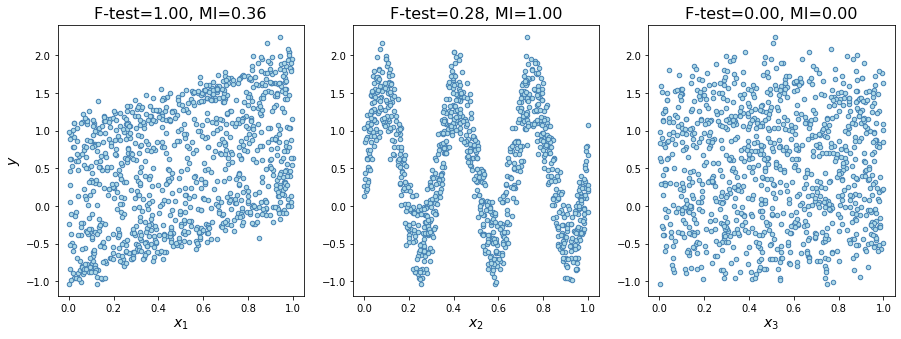

In [21]:

np.random.seed(0)
X = np.random.rand(1000, 3)
y = X[:, 0] + np.sin(6 * np.pi * X[:, 1]) + 0.1 * np.random.randn(1000)

f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

plt.style.use('default')
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X[:, i], y, edgecolor="steelblue", s=20, color='lightblue')
    # plt.scatter(X[:, i], y, color="steelblue", s=20, edgecolor='lightblue')
    plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]), fontsize=16)
plt.show()

# Compute Statistics

In [22]:
X, y = X_y_split(dataframe_core)

In [23]:


covariate_list  = []
dtype_list      = []
f_test_list     = []
p_value_list    = []
mi_list         = []
failed          = []
y = dataframe_core[['wcst_accuracy']]





for col in X.columns:
    x = X[[col]]


    # Continuous ----------------------------*
    if (x.dtypes == float)[0] or (x.dtypes==int)[0]:

        dtype_list.append('float')

        # append data ---------------------------* 
        x['y']  = y
        x       = x.drop_duplicates()

        # Mutual information --------------------*
        a = [] 
        for _ in range(100) : a.append(mutual_info_regression(X=x.loc[:, x.columns!='y'], y=x[['y']]))
        mi = np.mean(a)

        # Prepare DataFrame ---------------------*
        cols    = [c for c in x.columns if c != 'y']
        func    = 'y ~ ' + ' + '.join(cols)
        ols_    = ols(func, data=x).fit()
        a       = sm.stats.anova_lm(ols_)
        F       = a['F'][0]
        p_value = a['PR(>F)'][0]
        
        # option B - equavalent ----------------------*
        # func        = col + ' ~ y'
        # ols_        = ols(func, data=x).fit()
        # a           = sm.stats.anova_lm(ols_)
        # F_          = a['F'][0]
        # p_value_    = a['PR(>F)'][0]

        # option C - equavalent ----------------------*
        # F__, p_value__ = f_regression(x.loc[:,x.columns!='y'], x['y'])


    # Discrete ------------------------------*
    if x.dtypes[0] == 'string[python]':
        dtype_list.append('object')
        
        # append data ---------------------------* 
        x['y']  = y
        x       = x.drop_duplicates()

        # Mutual information --------------------*
        if True: 
            for _ in range(100):
                a = []
                a.append(mutual_info_classif(X=x[['y']], y=x[col]))
                mi = np.mean(a)

        # mi = np.NAN


        # option C - equavalent ----------------------*
        F, p_value = f_classif(X=x[['y']], y=x[col])
        F = F[0]
        p_value = p_value[0]


    # Store ---------------------------------*
    covariate_list.append(col)
    f_test_list.append(F)
    p_value_list.append(p_value)
    mi_list.append(mi)



data_ = pd.DataFrame(
    {'covariate':covariate_list, 
    'dtype':dtype_list,
    'f_test':f_test_list, 
    'p_value':p_value_list, 
    'mi':mi_list})
data_.round(4)  


,covariate,dtype,f_test,p_value,mi
0,nback_status,float,60.9529,0.0000,0.0684
1,nback_reaction_time_ms,float,5.3059,0.0222,0.0424
2,fitts_mean_deviation,float,31.3695,0.0000,0.0884
3,corsi_block_span,float,20.7242,0.0000,0.0000
4,wcst_RT,float,111.3831,0.0000,0.1933
5,demographics_age_a,float,2.0159,0.1573,0.0019
6,demographics_gender_a,object,1.6373,0.2017,0.0000
7,demographics_handedness_a,object,1.5185,0.2276,0.0000
8,demographics_education_a,object,3.0206,0.0540,0.0000
9,demographics_income_a,float,9.4721,0.0025,0.0000


# mRMR

In [24]:
# Split data ----------------------*
X, y = X_y_split(dataframe_core)

# get variable types --------------*
continous   = []
discrete    = []
for cl in X.columns:
    if (X[cl].dtypes == float) or (X[cl].dtypes == int): continous.append(cl)
    if X[cl].dtypes == 'string': discrete.append(cl)

# mRMR random forest/corr ---------*
mrmr_RF = mrmr_regression(X=X, y=y, K=X.shape[1],  cat_features=discrete, relevance='rf')

# mRMR F-stat/corr ----------------*
mrmr_F  = mrmr_regression(X=X, y=y, K=X.shape[1],  cat_features=discrete, relevance='f')

100%|██████████| 16/16 [00:03<00:00,  4.74it/s]


In [26]:
mrmr_data = pd.DataFrame({'mrmr_RF':mrmr_RF}).join(pd.DataFrame({'mrmr_F':mrmr_F}))
data_

# create dataframe ----------------------*
mrmr            = pd.DataFrame({'covariate':mrmr_RF})
mrmr.index      = mrmr.index.set_names('mrmr_RF_rank')
mrmr            = mrmr.reset_index().set_index('covariate')

mrmr_f          = pd.DataFrame({'covariate':mrmr_F})
mrmr_f.index    = mrmr_f.index.set_names('mrmr_F_rank')
mrmr_f          = mrmr_f.reset_index().set_index('covariate')


# join ----------------------------------*
final_dataset = data_.set_index('covariate').join(mrmr.join(mrmr_f))
final_dataset.round(4)

,dtype,f_test,p_value,mi,mrmr_RF_rank,mrmr_F_rank
covariate,,,,,,
nback_status,float,60.9529,0.0000,0.0684,5,2
nback_reaction_time_ms,float,5.3059,0.0222,0.0424,7,1
fitts_mean_deviation,float,31.3695,0.0000,0.0884,6,4
corsi_block_span,float,20.7242,0.0000,0.0000,15,3
wcst_RT,float,111.3831,0.0000,0.1933,2,0
demographics_age_a,float,2.0159,0.1573,0.0019,1,13
demographics_gender_a,object,1.6373,0.2017,0.0000,4,8
demographics_handedness_a,object,1.5185,0.2276,0.0000,0,5
demographics_education_a,object,3.0206,0.0540,0.0000,3,11


# EXPORT *******************************************************************************************

In [28]:
!pip install openpyxl
import openpyxl

final_dataset.to_excel('./final_variable_ranking.xlsx')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 1.5 MB/s eta 0:00:00a 0:00:01
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)


# SAVE FINAL DATAFRAMES ****************************************************************************

In [31]:

# wcst performance -------------------------*
bp.raw.wcst_data.head()


# aggregate dataframe ----------------------*
dataframe_core.head()

# create location --------------------------*
store_loc = '../data objects/final_dataframes'
if not os.path.exists(store_loc): os.mkdir(store_loc)


# save -------------------------------------*
bp.raw.wcst_data.to_pickle(os.path.join(store_loc,  'wcst_raw_data.pkl'))
dataframe_core.to_pickle(os.path.join(store_loc,    'covariates.pkl'))

bp.raw.wcst_data.to_csv(os.path.join(store_loc,  'wcst_raw_data.csv'))
dataframe_core.to_csv(os.path.join(store_loc,    'covariates.csv'))
